In [76]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import torchvision
import matplotlib.pyplot as plt


torch.cuda.is_available()

True

In [2]:
celeba_train = torchvision.datasets.CelebA(root="data/", split="train", target_type='identity', download=True, transform=torchvision.transforms.ToTensor())
celeba_valid = torchvision.datasets.CelebA(root="data/", split="valid", target_type='identity', download=True, transform=torchvision.transforms.ToTensor())
# celeba_test = torchvision.datasets.CelebA(root="data/", split="test", download=True)

Files already downloaded and verified
Files already downloaded and verified


In [93]:
# Custom sampler class that generates batches with of triplets of images
class TripletSampler(torch.utils.data.sampler.Sampler):
    def __init__(self, dataset):
        self.dataset = dataset

    def __getitem__(self, i):
        # Get a random anchor image and its identity
        _, anchor_identity = self.dataset[i]
        # Get all indexes with the same identity
        same_identity_idx = torch.where(self.dataset.identity == anchor_identity)[0]
        # remove the anchor image from the list
        same_identity_idx = same_identity_idx[same_identity_idx != i]
        # Get a random positive image
        positive_idx = same_identity_idx[torch.randint(len(same_identity_idx), (1,))]
        # Get all indexes with different identities
        different_identity_idx = torch.where(self.dataset.identity != anchor_identity)[0]
        # Get a random negative image
        negative_idx = different_identity_idx[torch.randint(len(different_identity_idx), (1,))]
        return (i, positive_idx.item(), negative_idx.item())

    def __iter__(self):
        for i in range(len(self.dataset)):
            yield self[i]

    def __len__(self):
        return len(self.dataset)



class TripletDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __getitem__(self, triplet_idx):
        anchor_idx, positive_idx, negative_idx = triplet_idx
        a_img, a_label = self.dataset[anchor_idx]
        p_img, p_label = self.dataset[positive_idx]
        n_img, n_label = self.dataset[negative_idx]
        assert a_label == p_label and a_label != n_label
        return (a_img, p_img, n_img), (a_label.item(), p_label.item(), n_label.item())

    def __len__(self):
        return len(self.dataset)

def collate_fn(batch):
    # from 2 x 3 x 16 x (img) to 2 x 16 x 3 x (img)
    batch = list(zip(*batch))
    return batch



triplet_sampler = TripletSampler(celeba_train)
triplet_dataset = TripletDataset(celeba_train)
triplet_data_loader = torch.utils.data.DataLoader(  triplet_dataset,
                                                    batch_size=16,
                                                    #shuffle=False, # Should be True later
                                                    num_workers=0,
                                                    sampler=triplet_sampler,
                                                    # collate_fn=collate_fn
                                                  )
triplet_iter = iter(triplet_data_loader)

In [94]:
def plot_triplet(imgs, labels):
    fig, ax = plt.subplots(1, 3, figsize=(10, 10))
    titles = ["Anchor", "Positive", "Negative"]
    for i, img in enumerate(imgs):
        ax[i].imshow(img.permute(1, 2, 0))
        # ax[i].set_title(f"Identity: {labels[i]}")
        ax[i].set_title(titles[i] + f"\nIdentity: {labels[i]}")
        ax[i].axis('off')
    plt.show()

In [158]:
example_iter = iter(range(1000))

Triplet Batch size:
2 x 3 x 16 x 3 x 218 x 178


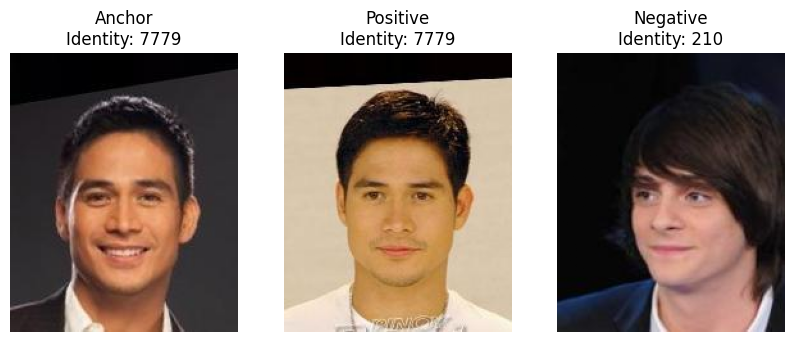

In [170]:
# A triplet batch is (Labels, Images) x (Anchor, Positive, Negative) x Batch Size x Channels x Height x Width
# = 2 x 3 x 16 x 3 x 218 x 178

def example():
    # triplet_batch = next(triplet_iter)
    # imgs = [triplet_batch[0][0][0], triplet_batch[0][1][0], triplet_batch[0][2][0]]
    # labels = [triplet_batch[1][0][0], triplet_batch[1][1][0], triplet_batch[1][2][0]]
    # plot_triplet(imgs, labels)

    idx = triplet_sampler[next(example_iter)]
    triplet_batch = triplet_dataset.__getitem__(idx)
    print("Triplet Batch size:")
    print(len(triplet_batch), len(triplet_batch[0]), "16", len(triplet_batch[0][0]), *triplet_batch[0][0][0].shape, sep=' x ')
    plot_triplet(triplet_batch[0], triplet_batch[1])
    
example()

In [82]:
class TripletNet(nn.Module):
    def __init__(self):
        super(TripletNet, self).__init__()
        self.resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        self.resnet.fc = nn.Identity()
        self.fc = nn.Linear(512, 1000)

    def forward(self, anchor, positive, negative):
        anchor = self.resnet(anchor)
        positive = self.resnet(positive)
        negative = self.resnet(negative)
        anchor = self.fc(anchor)
        positive = self.fc(positive)
        negative = self.fc(negative)
        return anchor, positive, negative


def train_triplet_net(triplet_net, triplet_data_loader, epochs=1, lr=0.001):
    optimizer = optim.Adam(triplet_net.parameters(), lr=lr)
    criterion = nn.TripletMarginLoss(margin=1.0, p=2)
    for epoch in range(epochs):
        running_loss = 0.0
        for i, triplet_batch in enumerate(triplet_data_loader):
            optimizer.zero_grad()
            anchor, positive, negative = triplet_batch[0]
            anchor, positive, negative = anchor.cuda(), positive.cuda(), negative.cuda()
            anchor, positive, negative = triplet_net(anchor, positive, negative)
            loss = criterion(anchor, positive, negative)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if i % 100 == 99:
                print(f"Epoch: {epoch + 1}, Batch: {i + 1}, Loss: {running_loss / 100}")
                running_loss = 0.0
            if i == 100:
                break
    print("Finished Training")


def test_triplet_net(triplet_net, triplet_data_loader):
    triplet_net.eval()
    with torch.no_grad():
        for i, triplet_batch in enumerate(triplet_data_loader):
            anchor, positive, negative = triplet_batch[0]
            anchor, positive, negative = anchor.cuda(), positive.cuda(), negative.cuda()
            anchor, positive, negative = triplet_net(anchor, positive, negative)
            break


triplet_net = TripletNet()
triplet_net.cuda()
triplet_net.train()

train_triplet_net(triplet_net, triplet_data_loader, epochs=3, lr=0.001)
test_triplet_net(triplet_net, triplet_data_loader)

Epoch: 1, Batch: 100, Loss: 1.0776323463022708
Epoch: 2, Batch: 100, Loss: 0.5766770242154599
Epoch: 3, Batch: 100, Loss: 0.49216523982584476
Finished Training


In [84]:
torch.save(triplet_net.state_dict(), "models/triplet_net.pt")

In [ ]:
triplet_net = TripletNet()
triplet_net.load_state_dict(torch.load("models/triplet_net.pt"))
triplet_net.cuda()

## Plots

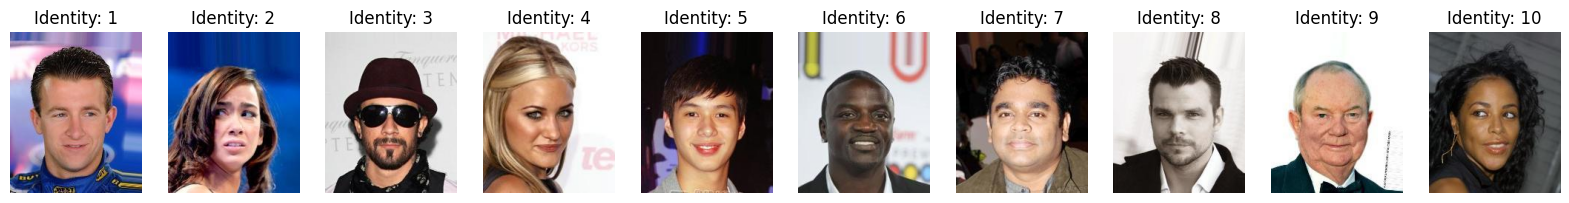

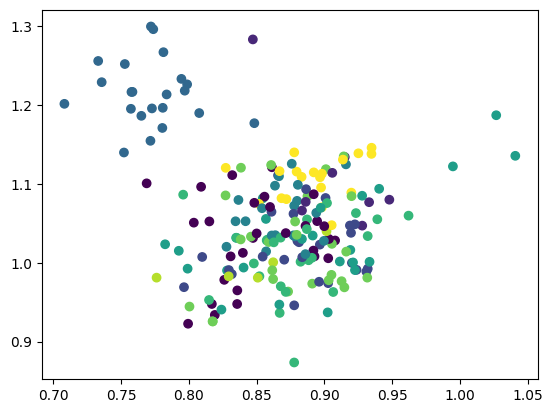

Identity with largest embedding value:
[6]
Identity with lowest embedding value:
[4]


c:\Users\Andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\Andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


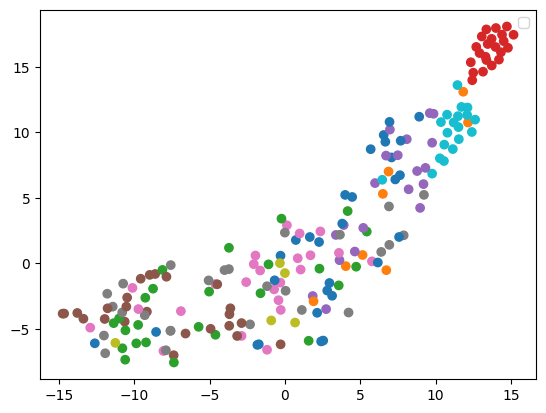

Identity with largest TNES value:
[4]
Identity with lowest TNES value:
[6]


In [144]:
# Show the embeddings of the all images of the first 10 people

# get all images of the first 10 people
first_10_idx = torch.where(celeba_train.identity <= 10)[0]

# get all embeddings of triplet_net of the first 10 people
first_10_embeddings = []
# first_10_imgs = []
for i in first_10_idx:
    img, label = celeba_train[i]
    # first_10_imgs.append(img)
    img = img.cuda()
    img = img.unsqueeze(0)
    embedding = triplet_net.resnet(img)
    first_10_embeddings.append(embedding)

first_10_labels = celeba_train.identity[first_10_idx].numpy()

# find first image of each of the first 10 people
first_10_imgs = []
for i in range(1,11):
    idx = torch.where(celeba_train.identity == i)[0][0]
    img, label = celeba_train[idx]
    first_10_imgs.append(img)

# show one image of each of the first 10 people
fig, ax = plt.subplots(1, 10, figsize=(20, 20))
for i, img in enumerate(first_10_imgs):
    ax[i].imshow(img.permute(1, 2, 0))
    ax[i].set_title(f"Identity: {i + 1}")
    ax[i].axis('off')
plt.show()

# plot the embeddings of the first 10 people
first_10_embeddings = torch.stack(first_10_embeddings)
first_10_embeddings = first_10_embeddings.squeeze(1)
first_10_embeddings = first_10_embeddings.cpu().detach().numpy()
plt.scatter(first_10_embeddings[:, 0], first_10_embeddings[:, 1], c=first_10_labels)
plt.show()

# print identity with lowest and largest embedding value
max_idx = np.argmax(first_10_embeddings[:, 0])
print("Identity with largest embedding value:")
print(first_10_labels[max_idx])
min_idx = np.argmin(first_10_embeddings[:, 0])
print("Identity with lowest embedding value:")
print(first_10_labels[min_idx])

# Show the embeddings of the first 10 people with TSNE
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
first_10_embeddings_tsne = tsne.fit_transform(first_10_embeddings)
# show legend with 10 identities
plt.legend([f"Identity: {i + 1}" for i in range(10)])
plt.scatter(first_10_embeddings_tsne[:, 0], first_10_embeddings_tsne[:, 1], c=first_10_labels, cmap='tab10')
plt.show()

# print identity with lowest and largest TNES value
max_idx = np.argmax(first_10_embeddings_tsne[:, 0])
print("Identity with largest TNES value:")
print(first_10_labels[max_idx])
min_idx = np.argmin(first_10_embeddings_tsne[:, 0])
print("Identity with lowest TNES value:")
print(first_10_labels[min_idx])
